# Pendahuluan

Market Basket Analysis adalah salah satu metode yang digunakan di berbagai industri untuk mengungkap asosiasi antara produk-produk dalam transaksi penjualan. Salah satu industri yang kerap melakukan MBA adalah indsutri perdagangan. Dengan ketatnya persaingan dan bertambahnya kompetitor di industri tersebut, memahami perilaku belanja pelanggan sangatlah penting untuk mengoptimalkan strategi penjualan, promosi, dan tata letak produk. Dengan menganalisis data transaksi, kita dapat mengidentifikasi pola pembelian, tren penjualan, dan menemukan hubungan antara produk-produk yang sering dibeli secara bersamaan. Data transaksi dapat memberikan wawasan berharga bagi pengambilan keputusan manajerial, terutama dalam mengembangkan strategi pemasaran yang lebih efektif dan efisien.

Berdasarkan kebutuhan tersebut, *case study* ini akan melaksanakan eksplorasi dan analisis terhadap data transaksi pembelian barang pada supermarket berdasarkan Groceries Dataset yang bersumber dari [Kaggle: Groceries Dataset](https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset/data). Dataset ini berisi informasi transaksi pembelian, termasuk tanggal transaksi, nomor pelanggan, serta deskripsi produk yang dibeli. Analisis akan dilakukan untuk memahami pola pembelian pelanggan, produk-produk yang paling sering dibeli, serta mendapatkan informasi terkait asosiasi produk berdasarkan pola pembelian.

# Tujuan

Pada tugas ini, analisis yang akan dilakukan dibagi ke dalam dua bagian utama, yaitu eksplorasi data dan analisis asosiasi:


**1.  Exploratory Data Analysis**

Tujuan dari eksplorasi ini adalah untuk memahami pola transaksi di supermarket berdasarkan beberapa aspek, seperti


*   Jumlah produk yang terjual: analisis ini akan dilakukan berdasarkan periode waktu untuk melihat tren penjualan secara keseluruhan.
*   Produk yang paling sering dibeli: mengidentifikasi produk-produk dengan frekuensi transaksi tertinggi, yang dapat menjadi indikasi produk favorit atau kebutuhan pokok pelanggan.
* Pelanggan dengan transaksi terbanyak: menemukan pelanggan dengan frekuensi pembelian paling sering, yang dapat membantu dalam strategi retensi dan program loyalitas.


**2. Market Basket Analysis**

Pada bagian ini, kami akan menggunakan algoritma apriori untuk menemukan aturan asosiasi antara produk-produk yang sering dibeli bersamaan. Tujuan dari analisis ini adalah untuk mendapatkan informasi berikut:


*   Itemset produk yang sering dibeli bersama: mengidentifikasi kombinasi produk yang sering dibeli dalam satu transaksi, yang bisa digunakan untuk strategi cross-selling atau promosi produk paket.
*   Hubungan antar produk berdasarkan support dan lift: Menemukan hubungan yang signifikan antar produk dengan metrik support, confidence, dan lift. Hal ini akan memberikan wawasan mengenai produk yang saling berkaitan dalam kebiasaan belanja pelanggan.


# Import and Data Feature


In [ ]:
pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from collections import Counter
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from tqdm import tqdm
import warnings
import time

warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv("https://drive.google.com/uc?export=download&id=15THWYV3Va2Dp07da0ONmr2AUHw7QcW05")

In [ ]:
data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


# Preprocessing dan Data Understanding

In [ ]:
print('Informasi Data')
data.info()

print('-----' * 13)

print('Missing Value Data')
print(data.isnull().sum())

Informasi Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB
-----------------------------------------------------------------
Missing Value Data
Member_number      0
Date               0
itemDescription    0
dtype: int64


Terlihat bahwa data di atas memiliki tiga kolom dengan 38.765 baris. Terlihat juga tidak terdapat missing value pada seluruh kolom.

In [ ]:
print('Jumlah Produk yang tersedia : ', data['itemDescription'].nunique())
print('List Produk yang tersedia : ')
list(data['itemDescription'].unique())

Jumlah Produk yang tersedia :  167
List Produk yang tersedia : 


['tropical fruit',
 'whole milk',
 'pip fruit',
 'other vegetables',
 'rolls/buns',
 'pot plants',
 'citrus fruit',
 'beef',
 'frankfurter',
 'chicken',
 'butter',
 'fruit/vegetable juice',
 'packaged fruit/vegetables',
 'chocolate',
 'specialty bar',
 'butter milk',
 'bottled water',
 'yogurt',
 'sausage',
 'brown bread',
 'hamburger meat',
 'root vegetables',
 'pork',
 'pastry',
 'canned beer',
 'berries',
 'coffee',
 'misc. beverages',
 'ham',
 'turkey',
 'curd cheese',
 'red/blush wine',
 'frozen potato products',
 'flour',
 'sugar',
 'frozen meals',
 'herbs',
 'soda',
 'detergent',
 'grapes',
 'processed cheese',
 'fish',
 'sparkling wine',
 'newspapers',
 'curd',
 'pasta',
 'popcorn',
 'finished products',
 'beverages',
 'bottled beer',
 'dessert',
 'dog food',
 'specialty chocolate',
 'condensed milk',
 'cleaner',
 'white wine',
 'meat',
 'ice cream',
 'hard cheese',
 'cream cheese ',
 'liquor',
 'pickled vegetables',
 'liquor (appetizer)',
 'UHT-milk',
 'candy',
 'onions',
 'ha

Terlihat bahwa terdapat 167 item yang dijual pada toko ini.

## Ekstraksi jumlah pembelian setiap barang yang dibeli pelanggan di hari H

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data['Frequency'] = data['Member_number'].map(data['Member_number'].value_counts())
data['Frequency_per_date'] = data.groupby(['Member_number', 'Date'])['itemDescription'].transform('count')
data['Item_Sold'] = data.groupby(['Date', 'itemDescription'])['itemDescription'].transform('count')

In [ ]:
# Melihat transaksi yang dilakukan oleh ID: 1249 sebagai contoh
data[data['Member_number'] == 1249]

,Member_number,Date,itemDescription,Frequency,Frequency_per_date,Item_Sold
10065,1249,2014-01-01,citrus fruit,5,2,1
12907,1249,2014-10-11,soda,5,3,2
26214,1249,2014-01-01,coffee,5,2,1
29056,1249,2014-10-11,frozen meals,5,3,2
36906,1249,2014-10-11,bottled beer,5,3,2


Berdasarkan hasil pengecekan data di atas, tipe data tiap variabel sudah sesuai dengan yang diperlukan untuk komputasi, yakni:
1. Kolom `Member_number` dengan tipe integer menunjukkan ID pelanggan, contohnya 1808, 2552, 2300.
2. Kolom `Date` dengan format YYYY-MM-DD menunjukkan tanggal transaksi dilakukan, contohnya 2015-07-21.
3. Kolom `itemDescription` dengan tipe object menunjukkan nama item yang dibeli dalam satu transaksi pada tanggal tertentu, contohnya tropical fruit, whole milk, dan lainnya.
4. Kolom `Frequency` dengan tipe integer menunjukkan jumlah total pembelian berbagai item oleh setiap pelanggan (berdasarkan ID `Member_number`) selama periode waktu yang tercatat dalam seluruh dataset. Misalnya, pelanggan dengan ID 1249 membeli macam-macam item sebanyak lima kali secara keseluruhan, sehingga nilai `Frequency` adalah 5.
5. Kolom `Frequency_per_date` dengan tipe integer menunjukkan jumlah transaksi yang dilakukan oleh pelanggan pada tanggal tertentu. Sebagai contoh, pada tanggal "2014-01-01", pelanggan dengan ID 1249 melakukan dua kali transaksi, sehingga nilai `Frequency_per_date` adalah 2.
6. Kolom `Item_Sold` dengan tipe integer menunjukkan jumlah unit suatu item tertentu yang dibeli berdasarkan tanggal transaksi, dengan mengabaikan ID pelanggan. Sebagai contoh, pada tanggal "2014-01-01", terdapat satu kali transaksi "citrus fruit", sehingga nilai `Item_Sold` adalah 1.

In [ ]:
data['Jumlah'] = data.groupby(['Member_number', 'Date', 'itemDescription'])['itemDescription'].transform('count')
data['All_time_sold'] = data.groupby('itemDescription')['itemDescription'].transform('count')
data = data.drop_duplicates()

In [ ]:
print('Interval pembelian produk : ' , '(', data['Jumlah'].min(), ',', data['Jumlah'].max(), ')')
print('Interval penjualan produk All time : ' , '(', data['All_time_sold'].min(), ',', data['All_time_sold'].max(), ')')

Interval pembelian produk :  ( 1 , 4 )
Interval penjualan produk All time :  ( 1 , 2502 )


In [ ]:
data[['Jumlah', 'All_time_sold']].describe()

,Jumlah,All_time_sold
count,38006.000000,38006.000000
mean,1.019971,787.398121
std,0.145071,677.136826
min,1.000000,1.000000
25%,1.000000,263.000000
50%,1.000000,571.000000
75%,1.000000,1071.000000
max,4.000000,2502.000000


# Exploratory Data Analysis

## Product Insight and Business Development

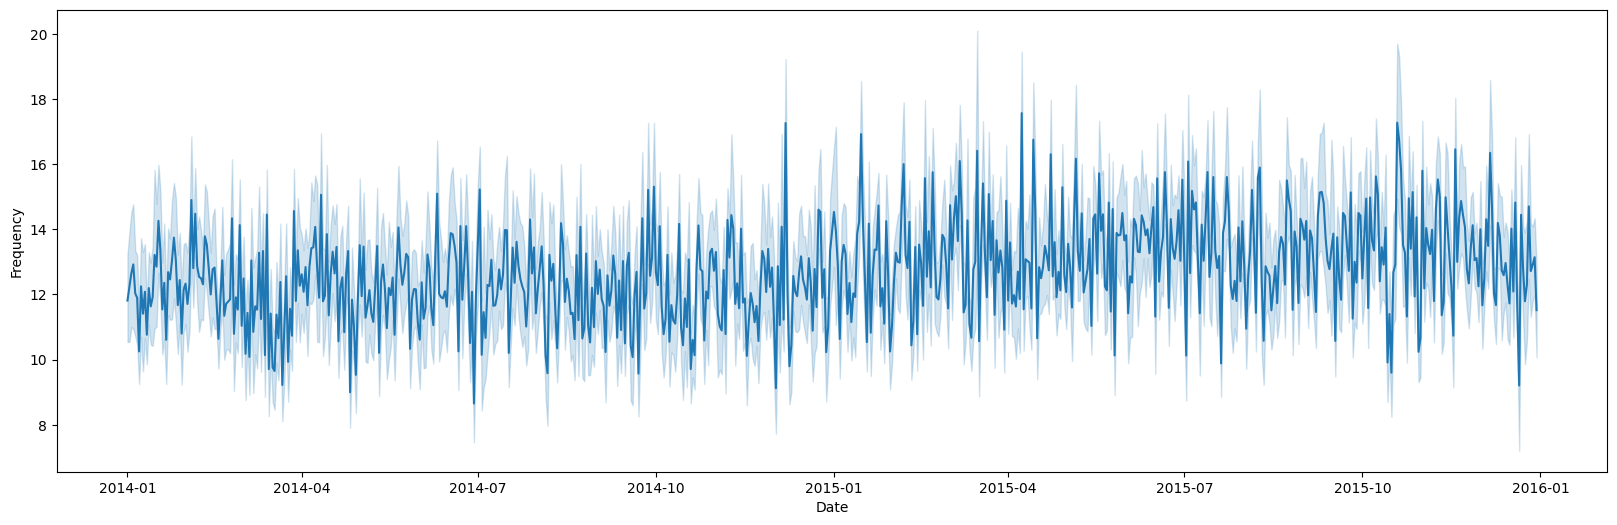

In [ ]:
plt.figure(figsize=(20, 6))
p = sns.lineplot(x='Date', y='Frequency', data=data)

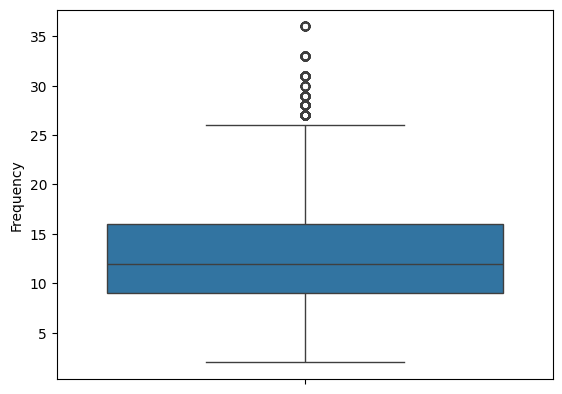

In [ ]:
p = sns.boxplot(y=data['Frequency'])

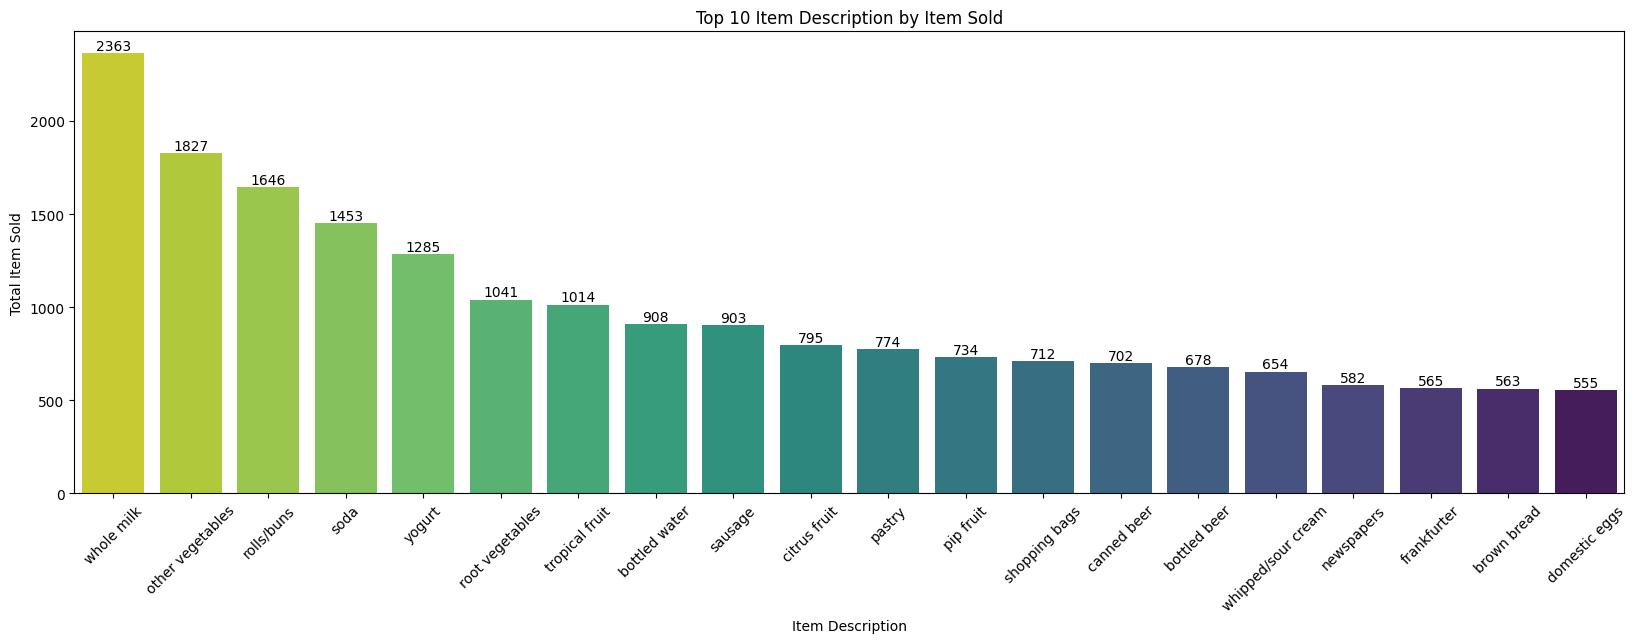

In [ ]:
item_freq = data.groupby('itemDescription')['itemDescription'].count().nlargest(20)
plt.figure(figsize=(20,6))
sns.barplot(x=item_freq.index, y=item_freq.values,palette='viridis_r')
for index, value in enumerate(item_freq.values):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')
plt.xticks(rotation=45)

plt.title('Top 10 Item Description by Item Sold')
plt.xlabel('Item Description')
plt.ylabel('Total Item Sold')

plt.show()

Produk Terlaris:

* Whole milk adalah produk terlaris dengan total penjualan sebanyak 2.502 unit, diikuti oleh other vegetables dan rolls/buns yang masing-masing terjual sebanyak 1.898 dan 1.716 unit.
* Produk seperti soda dan yogurt juga berada di daftar teratas, menunjukkan bahwa produk-produk harian yang biasa dikonsumsi oleh pelanggan memiliki tingkat penjualan yang tinggi.
Minuman dan Makanan Ringan:

* Soda dan bottled water masuk dalam daftar terlaris dengan penjualan masing-masing 1.514 dan 933 unit, menandakan bahwa minuman ringan adalah kategori penting dalam penjualan.
* Pastry dan sausage juga menunjukkan permintaan yang cukup tinggi di kategori makanan ringan.
Produk yang Masih Dibutuhkan:

* Produk-produk seperti whipped/sour cream, brown bread, dan domestic eggs ada di urutan terbawah, menunjukkan bahwa walaupun masih cukup diminati, produk ini mungkin memiliki ruang untuk peningkatan penjualan.
Saran untuk Mengoptimalkan Penjualan:

Program Bundling untuk Produk Populer:
* Karena whole milk, other vegetables, dan rolls/buns adalah produk yang sering dibeli, Penjual bisa menawarkan paket bundling yang menggabungkan produk-produk ini dengan diskon. Misalnya, "Beli Whole Milk, Sayuran, dan Roti Dapatkan Diskon 10%".
* Paket bundling yang berisi produk pelengkap juga bisa meningkatkan penjualan, misalnya menggabungkan pastry dengan yogurt atau sausage dengan bottled water.

Meningkatkan Penjualan Produk dengan Penjualan Sedang:
* Produk seperti bottled water, sausage, dan citrus fruit meskipun terjual cukup baik, masih bisa dioptimalkan dengan memberikan diskon khusus atau promosi "Beli 2 Gratis 1".
* Penjual juga bisa mempromosikan produk-produk ini di lokasi yang lebih strategis dalam toko, misalnya dekat kasir atau di pintu masuk.

Promosi Produk yang Kurang Laku:
* Produk-produk di urutan terbawah seperti brown bread, whipped/sour cream, dan domestic eggs dapat dipromosikan dengan memberikan diskon khusus atau penawaran seperti "Beli Whole Milk, Gratis Whipped Cream".
* Promosi ini bisa dilakukan di media sosial atau melalui aplikasi belanja online untuk menarik perhatian pelanggan yang mungkin belum memprioritaskan produk ini.
Penawaran Khusus untuk Produk yang Dibeli Bersama:

Analisis kebiasaan belanja pelanggan dapat membantu penjual menentukan produk yang sering dibeli bersama. Misalnya, whole milk mungkin sering dibeli bersama yogurt atau brown bread. Penawaran diskon ketika kedua produk dibeli bersamaan bisa meningkatkan penjualan total.

Sampling dan Cicipan Gratis:
* Untuk produk seperti whipped/sour cream atau brown bread, penjual bisa menawarkan sampel gratis kepada pelanggan di toko. Dengan memberikan pengalaman langsung kepada pelanggan, mereka mungkin lebih tertarik untuk mencoba dan membeli produk tersebut.

Promosi Musiman atau Event Khusus:
* Soda dan bottled water bisa dipromosikan lebih agresif selama musim panas, atau selama event tertentu seperti liburan atau acara olahraga. Menawarkan diskon selama periode-periode ini bisa meningkatkan volume penjualan secara signifikan.
* Pastry dan sausage juga bisa dipromosikan lebih banyak saat ada acara keluarga atau liburan dengan diskon khusus atau paket snack.

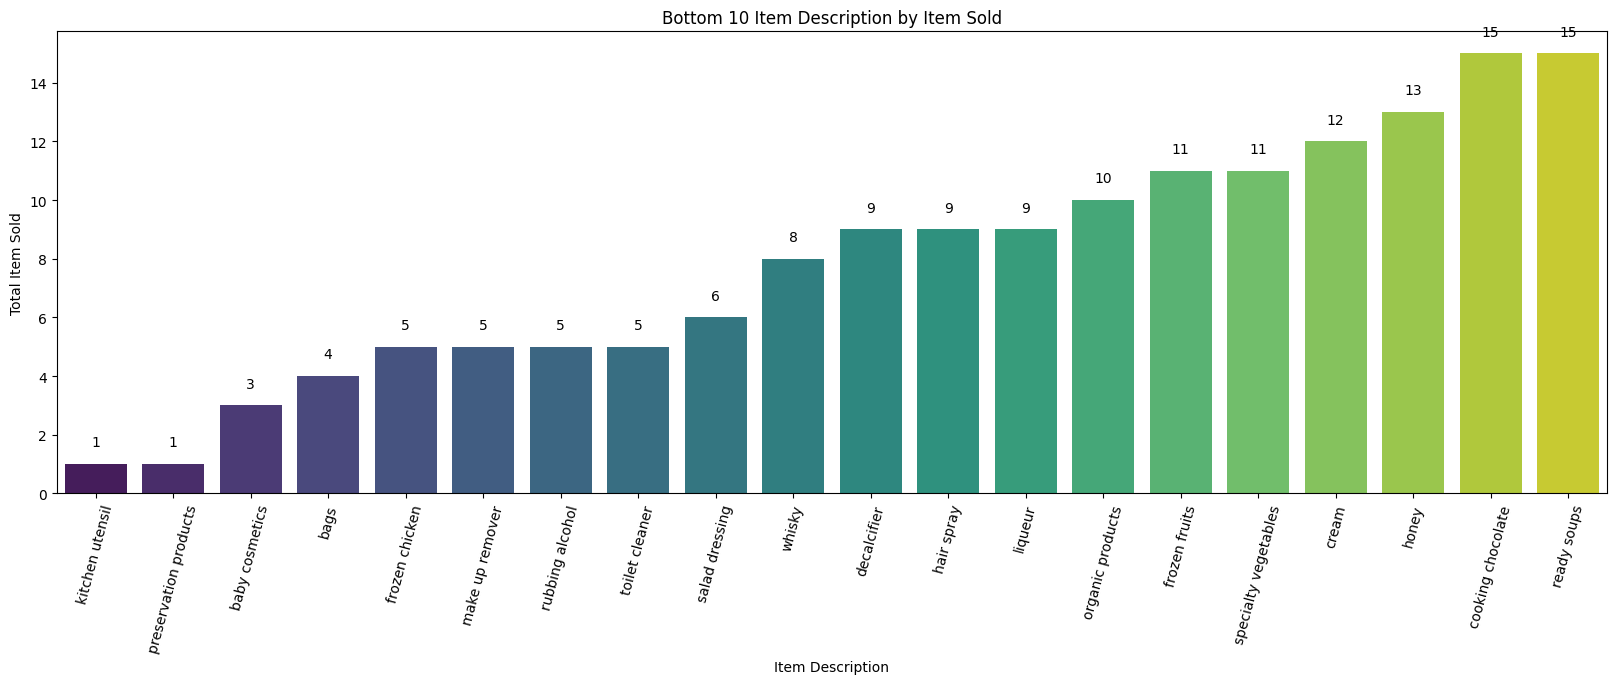

In [ ]:
item_freq1 = data.groupby('itemDescription')['itemDescription'].count().nsmallest(20)
plt.figure(figsize=(20,6))
sns.barplot(x=item_freq1.index, y=item_freq1.values,palette='viridis')
for index, value in enumerate(item_freq1.values):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')
plt.xticks(rotation=75)

plt.title('Bottom 10 Item Description by Item Sold')
plt.xlabel('Item Description')
plt.ylabel('Total Item Sold')

plt.show()

Produk dengan Penjualan Terendah:

* Kitchen utensil dan preservation products adalah produk dengan penjualan terendah (masing-masing hanya terjual 1 unit). Ini menunjukkan bahwa produk-produk ini mungkin tidak populer di kalangan pelanggan atau kurang dipromosikan dengan baik.
* Produk lain seperti baby cosmetics, bags, dan frozen chicken juga memiliki penjualan yang rendah dengan kurang dari 5 unit terjual.

Produk dengan Penjualan Lebih Moderat:
* Whisky, decalcifier, dan hair spray memiliki penjualan yang lebih baik (masing-masing terjual 8-9 unit), tetapi masih tergolong rendah jika dibandingkan dengan produk terlaris.
* Cooking chocolate dan ready soups menunjukkan performa sedikit lebih baik, masing-masing terjual 15 unit, tetapi masih berada di urutan terbawah secara keseluruhan.

Saran untuk Meningkatkan Penjualan:

Penempatan Produk yang Lebih Strategis:
* Produk dengan penjualan terendah seperti kitchen utensil dan preservation products bisa dipindahkan ke lokasi yang lebih terlihat di toko, misalnya dekat kasir atau di bagian depan toko. Tempatkan mereka di area yang sering dilalui oleh pelanggan untuk meningkatkan visibilitasnya.
* Produk seperti baby cosmetics bisa ditempatkan di dekat produk bayi lain yang lebih laku, sehingga mendorong pelanggan untuk membeli produk tambahan.

Paket Promosi dan Diskon:
* Untuk meningkatkan penjualan produk seperti frozen chicken, make up remover, dan toilet cleaner, Penjual bisa menawarkan paket bundling dengan produk lain yang lebih laku. Misalnya, Penjual bisa menawarkan diskon untuk pembelian frozen chicken bersama produk sayuran segar.
* Buat promosi Beli 2 Gratis 1 atau diskon besar-besaran untuk produk-produk dengan penjualan rendah seperti bags dan rubbing alcohol.

Edukasi Pelanggan tentang Manfaat Produk:
* Beberapa produk mungkin kurang diminati karena pelanggan kurang paham mengenai kegunaannya. Produk seperti decalcifier atau preservation products bisa dipromosikan dengan kampanye edukasi yang menjelaskan cara dan manfaat penggunaannya. Brosur atau materi promosi di toko bisa membantu meningkatkan pemahaman dan minat beli.
* Organic products dan specialty vegetables bisa dipromosikan dengan penekanan pada manfaat kesehatan yang ditawarkan oleh produk-produk organik.

Penawaran Sampling atau Cicipan Gratis:
* Untuk produk seperti whisky, salad dressing, atau ready soups, penjual bisa menawarkan sampel gratis di toko. Memberikan pelanggan kesempatan untuk mencicipi produk sebelum membeli sering kali dapat meningkatkan kemungkinan pembelian.
* Ini bisa dilakukan pada acara-acara tertentu atau selama akhir pekan untuk meningkatkan antusiasme.

Promosi Musiman atau Event Khusus:
* Produk-produk seperti whisky atau cooking chocolate mungkin lebih relevan selama musim liburan atau acara tertentu. Buat promosi khusus selama hari-hari besar atau event musim dingin untuk meningkatkan penjualan.
* Buat event bertema yang mengaitkan produk-produk ini dengan perayaan atau tren musiman untuk menarik perhatian pelanggan.

Penggunaan Paket Hadiah:
* Produk-produk yang biasanya kurang laku, seperti bags atau baby cosmetics, dapat dijadikan bagian dari paket hadiah. Misalnya, buat paket perawatan bayi yang menggabungkan baby cosmetics dengan produk bayi lain yang lebih laris, lalu tawarkan sebagai hadiah dengan harga khusus.

Eksperimen dengan Harga:
* Pertimbangkan untuk menurunkan harga sementara untuk produk dengan penjualan rendah seperti preservation products atau frozen chicken. Ini bisa menarik minat pelanggan baru dan meningkatkan penjualan.
Buat promosi "Harga Diskon" atau flash sale untuk produk-produk ini selama jangka waktu terbatas.

In [ ]:
data.head()

,Member_number,Date,itemDescription,Frequency,Frequency_per_date,Item_Sold,Jumlah,All_time_sold
0,1808,2015-07-21,tropical fruit,10,3,3,1,1032
1,2552,2015-01-05,whole milk,13,3,6,1,2502
2,2300,2015-09-19,pip fruit,10,3,3,1,744
3,1187,2015-12-12,other vegetables,7,3,2,1,1898
4,3037,2015-02-01,whole milk,5,3,9,1,2502


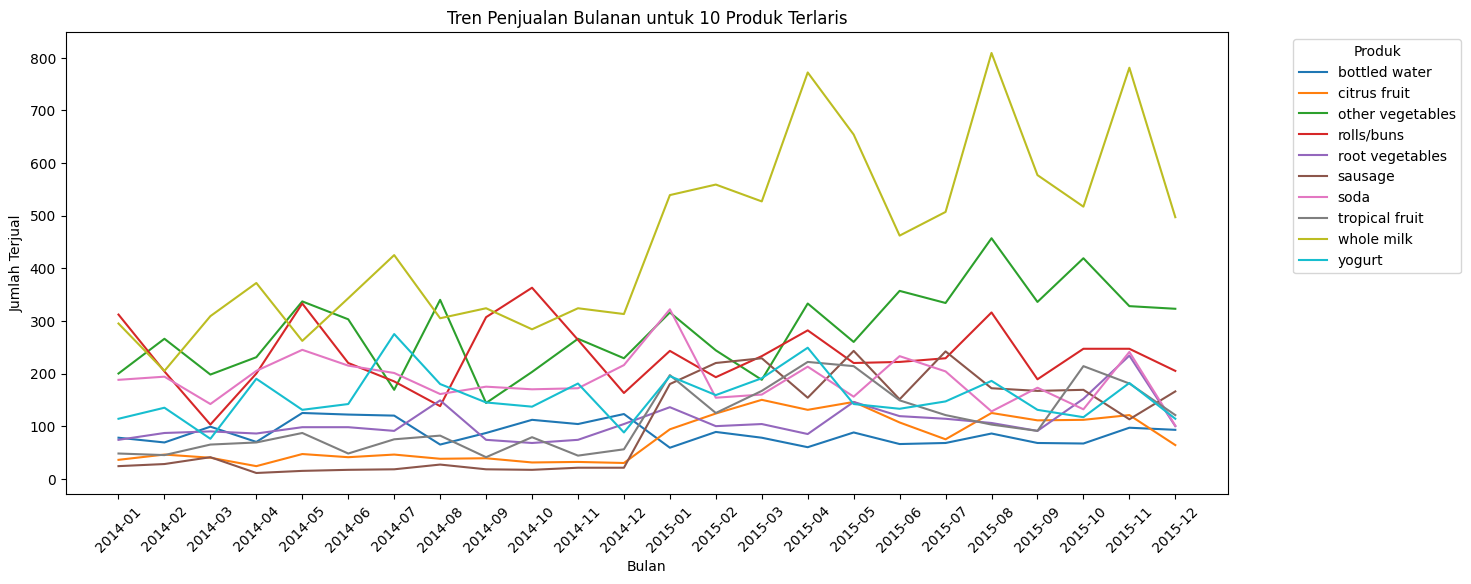

In [ ]:
popular_products10 = data.groupby('itemDescription')['Item_Sold'].sum().sort_values(ascending=False).head(10).index
popular_products_10 = data[data['itemDescription'].isin(popular_products10)]

popular_products_10['Month'] = popular_products_10['Date'].dt.to_period('M').astype(str)
product_per_month = (
    popular_products_10.groupby(['Month', 'itemDescription'])['Item_Sold']
    .sum()
    .reset_index()
)

plt.figure(figsize=(15, 6))
sns.lineplot(data=product_per_month, x='Month', y='Item_Sold', hue='itemDescription')

# Konfigurasi visualisasi
plt.title('Tren Penjualan Bulanan untuk 10 Produk Terlaris')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Terjual')
plt.xticks(rotation=45)
plt.legend(title='Produk', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

* Whole Milk adalah produk dengan penjualan tertinggi secara konsisten, mencapai lebih dari 600 unit terjual pada beberapa bulan, khususnya pada paruh kedua tahun 2015.

* Other Vegetables dan Rolls/Buns juga termasuk produk yang sering terjual dalam jumlah besar, meskipun mereka menunjukkan fluktuasi penjualan yang lebih tajam dibandingkan Whole Milk.

* Produk seperti Yogurt, Soda, Sausage, dan Citrus Fruit menunjukkan penjualan yang lebih rendah secara konsisten, dengan beberapa di antaranya hanya mencapai sekitar 100-200 unit terjual dalam bulan-bulan tertentu.

* Beberapa produk menunjukkan penjualan yang relatif stabil, misalnya Bottled Water dan Root Vegetables, yang tidak mengalami fluktuasi drastis.

## Customer Insight

In [ ]:
top_20_members = data['Member_number'].value_counts().nlargest(20)

top_20_members = top_20_members.sort_values(ascending=False)
top_20_members

,count
Member_number,
3180,35
3737,33
3050,32
2051,31
2625,30
2433,30
3915,30
2851,29
2394,29


1. **Program Loyalty dan Reward**

* Poin Loyalty: Setiap kali pelanggan melakukan transaksi, mereka dapat mengumpulkan poin yang bisa ditukarkan dengan diskon atau hadiah. Semakin sering mereka berbelanja, semakin banyak poin yang dikumpulkan. Ini akan memotivasi mereka untuk terus kembali.
* Status Pelanggan VIP: Buat tingkatan pelanggan, seperti Gold, Silver, dan Platinum, yang memberikan keuntungan khusus untuk pelanggan yang sering berbelanja, seperti akses ke penawaran eksklusif, diskon khusus, atau layanan prioritas.
2. **Personalized Offers**

* Promosi yang Disesuaikan: Gunakan data riwayat pembelian untuk memberikan penawaran atau diskon yang sesuai dengan preferensi belanja mereka. Misalnya, jika seorang pelanggan sering membeli susu dan roti, maka penjual bisa mengirimkan diskon khusus untuk produk tersebut.
* Penawaran Ulang Tahun: Kirimkan penawaran spesial atau hadiah pada hari ulang tahun pelanggan, membuat mereka merasa dihargai.
Diskon Khusus untuk Transaksi Berikutnya
Berikan diskon khusus untuk pembelian berikutnya setelah transaksi tertentu. Ini akan memberikan insentif langsung untuk mereka melakukan transaksi lagi dalam waktu dekat.
3. **Diskon Khusus untuk Transaksi Berikutnya**

* Memberikan diskon khusus untuk pembelian berikutnya setelah transaksi tertentu. Ini akan memberikan insentif langsung untuk mereka melakukan transaksi lagi dalam waktu dekat.

## Month Insight

In [ ]:
data2 = data.copy()
data2['Date'] = pd.to_datetime(data2['Date'])
data2['Month'] = data2['Date'].dt.to_period('M')

monthly_sales = data2.groupby(['Month', 'itemDescription']).size().reset_index(name='Count')
top_3_items_per_month = monthly_sales.groupby('Month').apply(lambda x: x.nlargest(3, 'Count')).reset_index(drop=True)

top_3_items_per_month

,Month,itemDescription,Count
0,2014-01,rolls/buns,82
1,2014-01,whole milk,78
2,2014-01,other vegetables,62
3,2014-02,other vegetables,75
4,2014-02,soda,64
...,...,...,...
67,2015-11,other vegetables,85
68,2015-11,soda,75
69,2015-12,whole milk,102
70,2015-12,other vegetables,87


In [ ]:
item_frequency_in_top3 = top_3_items_per_month['itemDescription'].value_counts().reset_index()
item_frequency_in_top3.columns = ['itemDescription', 'Frequency']
item_frequency_in_top3

,itemDescription,Frequency
0,whole milk,24
1,other vegetables,20
2,rolls/buns,12
3,soda,11
4,sausage,4
5,yogurt,1


1. Whole Milk (24 kali) & Other Vegetables (20 kali):
* Rekomendasi Promosi dan Bundling:
Whole milk dan other vegetables sangat sering muncul dalam top 3, yang berarti mereka adalah produk populer di kalangan pelanggan. Toko dapat memanfaatkan popularitas ini dengan membuat bundling atau paket diskon yang menggabungkan produk ini dengan produk lain yang mungkin memiliki penjualan lebih rendah, seperti sausage atau yogurt. Misalnya, "Beli whole milk dan sayuran, dapatkan diskon untuk produk daging."
* Cross-selling: Letakkan produk ini di area yang strategis di toko, seperti di bagian depan, atau buat kampanye pemasaran digital yang menawarkan diskon jika pelanggan membeli produk ini bersama-sama dengan produk lain.
2. Rolls/Buns (14 kali) & Soda (10 kali):
* Kombinasi Produk untuk Meningkatkan Penjualan:
Produk seperti rolls/buns dan soda sering kali dibeli bersama makanan siap saji atau produk sarapan. Penjual bisa membuat promosi paket seperti "Beli roti dan minuman soda, dapatkan diskon untuk snack." Hal ini dapat meningkatkan penjualan produk pendamping.
* Promosi Musiman: Produk seperti soda sering kali lebih laris selama acara khusus atau musim panas. Penjual bisa meningkatkan promosi selama periode ini dengan diskon musiman atau penawaran beli lebih banyak untuk mendapatkan harga yang lebih baik.
3. Sausage (3 kali) & Yogurt (1 kali):
* Meningkatkan Visibilitas Produk:
Sausage dan yogurt memiliki frekuensi kemunculan yang lebih rendah dalam top 3, meskipun masih termasuk dalam produk yang paling sering terjual. Penjual bisa meningkatkan visibilitas kedua produk ini dengan penempatan strategis di area yang sering dilalui pelanggan atau dengan memberikan potongan harga.
* Edukasi Konsumen: Produk seperti yogurt bisa dipromosikan dengan menekankan manfaat kesehatannya. Buat kampanye pemasaran yang menyoroti kandungan probiotik dan manfaat kesehatan lainnya dari yogurt.
Sampling Produk: Untuk produk seperti yogurt yang penjualannya rendah, tawarkan sampel gratis kepada pelanggan untuk meningkatkan minat.
4. Optimasi Kategori Produk Populer:
* Pengembangan Varian: Produk-produk seperti whole milk dan vegetables sangat populer, sehingga Penjual bisa mencoba menambah varian produk seperti produk susu organik atau sayuran premium yang menawarkan margin lebih tinggi, sehingga bisa memanfaatkan basis pelanggan yang sudah ada untuk menjual produk dengan nilai tambah.
5. Program Loyalitas untuk Produk Populer:
* Penjual bisa membuat program loyalitas yang menawarkan poin khusus atau diskon tambahan bagi pelanggan yang sering membeli produk populer seperti whole milk, vegetables, dan rolls/buns. Ini akan mendorong pelanggan untuk kembali dan meningkatkan frekuensi pembelian produk-produk ini.

# Market Basket Analysis

In [ ]:
basket = data.groupby(['Date', 'itemDescription'])['Jumlah']
basket.head()

,Jumlah
0,1
1,1
2,1
3,1
4,1
...,...
38760,1
38761,1
38762,1
38763,1


In [ ]:
basket = basket.sum().unstack().reset_index().fillna(0).set_index('Date')
basket.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,4.0,0.0
2014-01-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,4.0,1.0,0.0
2014-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0
2014-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0
2014-01-05,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0


In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.map(encode_units)
basket_sets = basket_sets.astype(bool)
basket_sets.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,True,False,False,False,False,False,False,False,False,True,...,False,False,True,True,False,False,False,True,True,False
2014-01-02,False,True,False,False,False,False,False,False,True,False,...,False,False,True,True,False,True,False,True,True,False
2014-01-03,False,False,False,False,False,False,False,False,True,False,...,False,False,True,True,False,True,False,True,True,False
2014-01-04,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,False,True,False
2014-01-05,True,True,False,False,False,False,True,False,False,True,...,False,True,False,True,False,True,False,True,True,False


In [ ]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False, na_position='last', inplace=True)

frequent_itemsets = frequent_itemsets[frequent_itemsets['support'] >= 0.1]
frequent_itemsets

,support,itemsets
101,0.957418,(whole milk)
64,0.914835,(other vegetables)
77,0.891484,(rolls/buns)
2137,0.875000,"(whole milk, other vegetables)"
2321,0.851648,"(whole milk, rolls/buns)"
...,...,...
318177,0.100275,"(sausage, rolls/buns, white bread, fruit/veget..."
985060,0.100275,"(tropical fruit, whipped/sour cream, rolls/bun..."
68796,0.100275,"(citrus fruit, whole milk, domestic eggs, butt..."
318219,0.100275,"(specialty bar, rolls/buns, fruit/vegetable ju..."


In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values(by='lift', ascending=False, na_position='last', inplace = True)
rules.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
14733153,"(sausage, rolls/buns, chicken, soda, bottled w...","(whole milk, frankfurter, pastry)",0.170330,0.288462,0.100275,0.588710,2.040860,0.051141,1.730015,0.614715
14733302,"(whole milk, frankfurter, pastry)","(sausage, rolls/buns, chicken, soda, bottled w...",0.288462,0.170330,0.100275,0.347619,2.040860,0.051141,1.271757,0.716772
14733224,"(sausage, chicken, soda, bottled water)","(whole milk, rolls/buns, frankfurter, pastry)",0.188187,0.263736,0.100275,0.532847,2.020377,0.050643,1.576065,0.622117
14733231,"(whole milk, rolls/buns, frankfurter, pastry)","(sausage, chicken, soda, bottled water)",0.263736,0.188187,0.100275,0.380208,2.020377,0.050643,1.309816,0.685954
13155284,"(whole milk, frankfurter, pork)","(sausage, pip fruit, bottled beer, citrus fruit)",0.251374,0.200549,0.101648,0.404372,2.016319,0.051236,1.342197,0.673295


In [ ]:
rules2 = rules[(rules['lift'] >= 1.5) & (rules['confidence'] >= 0.8)]

In [ ]:
rules2 = rules2.sort_values(by=['lift','confidence'], ascending=False, na_position='last')
rules2 = rules2.reset_index(drop=True)
rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(chicken, pork, root vegetables, citrus fruit)","(sausage, whole milk, tropical fruit)",0.123626,0.460165,0.101648,0.822222,1.786799,0.044760,3.036573,0.502457
1,"(chicken, frankfurter, pastry, citrus fruit)","(sausage, whole milk, tropical fruit)",0.123626,0.460165,0.101648,0.822222,1.786799,0.044760,3.036573,0.502457
2,"(chicken, frankfurter, canned beer, citrus fruit)","(sausage, whole milk, tropical fruit)",0.123626,0.460165,0.101648,0.822222,1.786799,0.044760,3.036573,0.502457
3,"(chicken, frankfurter, pastry, citrus fruit)","(sausage, whole milk, rolls/buns, soda)",0.123626,0.454670,0.100275,0.811111,1.783954,0.044065,2.887039,0.501439
4,"(chicken, frankfurter, bottled water, pastry)","(sausage, whole milk, rolls/buns, soda)",0.123626,0.454670,0.100275,0.811111,1.783954,0.044065,2.887039,0.501439
...,...,...,...,...,...,...,...,...,...,...
1275,"(tropical fruit, citrus fruit, yogurt, frankfu...","(sausage, whole milk, other vegetables)",0.144231,0.552198,0.119505,0.828571,1.500498,0.039862,2.612179,0.389771
1276,"(rolls/buns, citrus fruit, frankfurter, chicke...","(sausage, whole milk, other vegetables)",0.144231,0.552198,0.119505,0.828571,1.500498,0.039862,2.612179,0.389771
1277,"(chicken, frankfurter, bottled water, root veg...","(sausage, whole milk, rolls/buns)",0.137363,0.539835,0.111264,0.810000,1.500458,0.037111,2.421920,0.386648
1278,"(citrus fruit, frankfurter, berries)","(sausage, whole milk, rolls/buns)",0.137363,0.539835,0.111264,0.810000,1.500458,0.037111,2.421920,0.386648


## Insight






Agar dapat memahami data, interpretasi antecedents pertama adalah sebagai berikut:
 * Confidence sebesar 0.822222 menunjukkan bahwa dalam 82,22% kasus, jika seorang pelanggan membeli "citrus fruit, root vegetables, pork, dan chicken," mereka juga membeli "tropical fruit, sausage, dan whole milk."
 * Nilai lift sebesar 1.786799 mengindikasikan ada hubungan positif antara pembelian antecedents dan consequents. Dalam hal ini, 1.786799 berarti bahwa kemungkinan membeli "tropical fruit, sausage, dan whole milk" meningkat sebesar 78.68% ketika  "citrus fruit, root vegetables, pork, dan chicken" dibeli.

Dari hasil Market Basket Analysis (MBA) di atas, dapat diliidentifikasi pola pembelian produk-produk oleh pelanggan sehingga diperoleh informasi:
1. Pelanggan yang belanja kombinasi produk-produk seperti chicken, pork, root vegetables, citrus fruit, pastry, frankfurter, rolls/buns, bottled water, yogurt, berries, dan pip fruit selalu membeli sausage secara bersamaan dan begitu juga sebaliknya.
2. Pelanggan juga memiliki kecenderungan membeli sausage bersamaan dengan whole milk, soda, dan other vegetables.

# Rekomendasi

**Rekomendasi Pencatatan riwayat transaksi**
1. Toko dapat menambahkan kolom baru untuk mencatat merek dari setiap item yang terjual. Hal ini akan membantu menganalisis kinerja penjualan berdasarkan merek, mengetahui merek yang paling laris dan diminati, mengetahui preferensi pelanggan, serta membantu dalam negosiasi dengan distributor produk.
2. Toko dapat menambahkan kolom “Kategori Produk” untuk mengklasifikasikan barang ke dalam kategori yang lebih umum (misalnya produk susu, buah-buahan, sayuran, dan sebagainya). Hal ini dapat digunakan untuk menganalisis penjualan setiap kategori produk dan bukan hanya item individual, serta membantu dalam manajemen inventaris.
3. Toko dapat menambahkan kolom “Jumlah Terjual” dan “Harga Satuan” untuk setiap item yang dijual. Hal ini dapat membantu untuk melacak pendapatan dan volume penjualan dengan lebih efektif.
4. Toko dapat menambahkan kolom untuk menunjukkan apakah item tersebut dijual dalam kondisi promosi atau tidak. Hal ini akan membantu untuk menganalisis dampak diskon dan penawaran khusus terhadap penjualan.

**Rekomendasi Penjualan**
1. Untuk memaksimalkan penjualan, perusahaan dapat membuat promo paket bundling dengan produk pelengkap untuk produk populer. sedangkan produk yang kurang populer disarankan untuk dilakukan promosi musiman, evemt khusus, penawaran diskon berjenjang dan penempatan produk yang strategis.
2. Untuk meningkatkan keterlibatan dan loyalitas pelanggan, disarankan untuk membuat program loyalty dan reward seperti pengumpulan poin, status VIP, personalized offer, dan pemberian diskon pada transaksi berikutnya dengan memberikan insentif untuk berbelanja lebih sering.
3. Tempatkan produk seperti chicken, pork, root vegetables, citrus fruit, pastry, frankfurter, rolls/buns, bottled water, yogurt, berries, dan pip fruit berdekatan. Sausage bisa diletakkan di lokasi yang agak berjauhan agar pelanggan dapat melihat dan mungkin membeli produk lain sebelum membeli sausage.
4. Membuat paket bundling produk root vegetables dengan other vegetables dan menempatkan whole milk dan soda di dekat kasir.
5. Produk-produk yang sering dibeli bersamaan dengan barang utama (seperti sausage dan whole milk) dapat diberikan promosi, seperti “beli satu, gratis satu. Hal ini akan mendorong pelanggan untuk membeli lebih banyak produk dalam satu transaksi.



# Kesimpulan

Dari hasil eksplorasi data dan analisis yang dilakukan, dapat disimpulkan bahwa toko dapat meningkatkan pemahaman tentang pola transaksi dan mengoptimalkan strategi penjualan. Dalam Exploratory Data Analysis (EDA), tujuan untuk memahami jumlah produk yang terjual, produk dengan frekuensi tertinggi, serta pelanggan dengan transaksi terbanyak berhasil dicapai. Informasi ini memberikan dasar yang kuat untuk mengidentifikasi produk-produk unggulan serta merancang strategi retensi pelanggan melalui program loyalitas dan penawaran khusus bagi pelanggan yang sering bertransaksi.

Pada bagian Market Basket Analysis (MBA), tujuan untuk menemukan itemset produk yang sering dibeli bersama dan mengidentifikasi hubungan antarproduk berdasarkan support dan lift tercapai dengan baik. Hasil analisis menunjukkan bahwa produk, seperti chicken, citrus fruit, root vegetables, dan sausage sering dibeli bersamaan, yang membuka peluang untuk menerapkan strategi cross-selling dan bundling produk. Nilai lift yang tinggi pada beberapa pasangan produk menunjukkan adanya hubungan positif antarproduk sehingga toko dapat memanfaatkan informasi ini untuk memaksimalkan penjualan dengan promosi bundling atau penempatan produk yang strategis.

Secara keseluruhan, analisis ini memberikan wawasan yang penting dalam perencanaan penjualan dan strategi pemasaran berbasis data. Dengan memanfaatkan pola yang ditemukan, toko dapat meningkatkan efisiensi manajemen inventaris, memperkuat loyalitas pelanggan, dan mengoptimalkan pengalaman berbelanja yang lebih personal bagi konsumen.